In [2]:
# %%
# 0. Install Required Libraries if not already installed
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost wordcloud lightgbm

# 1. Import Libraries

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
# Step 1: Load Libraries
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from joblib import dump

In [ ]:
#  Step 2: Load and Prepare Dataset
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

In [68]:
fake.head()

,title,text,subject,date,label,domain
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,News
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,News
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,News
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,News
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,News


In [70]:
real.head()

,title,text,subject,date,label,domain
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,politicsNews


In [ ]:
# Add labels and domain info
fake['label'] = 0
real['label'] = 1

fake['domain'] = fake['subject']
real['domain'] = real['subject']

# Concatenate datasets
data = pd.concat([fake, real], axis=0).reset_index(drop=True)


In [ ]:
print("Dataset Shape (rows, columns):", data.shape)

Dataset Shape (rows, columns): (44898, 6)


In [61]:
print("\n First 5 Rows:")
print(data.head())


 First 5 Rows:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  donald trump sends out embarrassing new year’s...    News   
1  drunk bragging trump staffer started russian c...    News   
2  sheriff david clarke becomes an internet joke ...    News   
3  trump is so obsessed he even has obama’s name ...    News   
4  pope francis just called out donald trump duri...    News   

                date  label domain  
0  December 31, 2017      0   News  
1  December 31, 2017      0   News  
2  December 30, 2017      0   News  
3  December 29, 2017      0   News  
4  December 25, 2017      0   News  


In [62]:
print("\nColumn Names:")
print(data.columns.tolist())


Column Names:
['title', 'text', 'subject', 'date', 'label', 'domain']


In [63]:
print("\nDataset Info (Data Types & Missing Values):")
print(data.info())


Dataset Info (Data Types & Missing Values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
 5   domain   44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB
None


In [ ]:
print("\nSummary Statistics:")
print(data.describe(include='all'))


Summary Statistics:
                                                    title   text  \
count                                               44898  44898   
unique                                              38729  39095   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14      9   
mean                                                  NaN    NaN   
std                                                   NaN    NaN   
min                                                   NaN    NaN   
25%                                                   NaN    NaN   
50%                                                   NaN    NaN   
75%                                                   NaN    NaN   
max                                                   NaN    NaN   

             subject                date         label        domain  
count          44898               44898  44898.000000         44898  
unique             8

In [65]:

print("\n Missing Values in Dataset:")
print(data.isnull().sum())


 Missing Values in Dataset:
title      0
text       0
subject    0
date       0
label      0
domain     0
dtype: int64


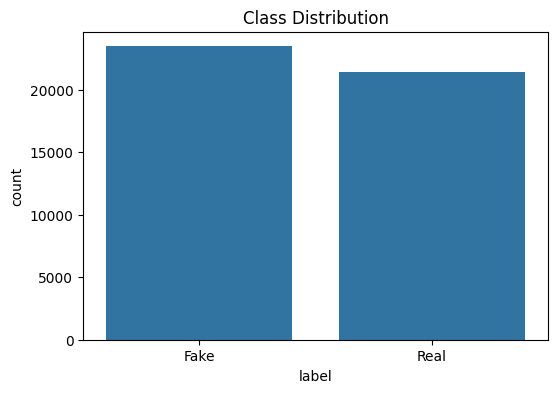

In [ ]:
# Class Distribution Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title("Class Distribution")
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title("Class Distribution")
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()

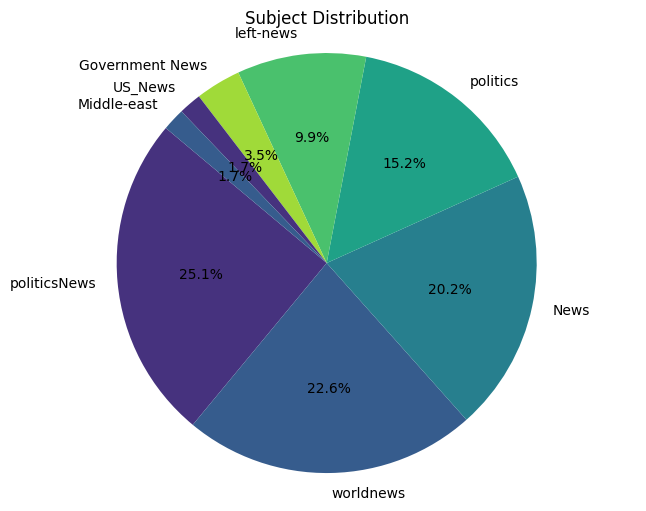

In [73]:
# Check subject distribution - Pie Chart
subject_counts = data['subject'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title("Subject Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [74]:
# Step 4: Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [75]:
# Step 5: Combine title + text and clean
data['text'] = data['title'] + ' ' + data['text']
data['text'] = data['text'].apply(clean_text)

In [76]:
# Step 6: Train/Test Split
X = data['text']
y = data['label']
domains = data['domain']

X_train, X_test, y_train, y_test, domain_train, domain_test = train_test_split(
    X, y, domains,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [77]:
# Step 7: Vectorize with TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### Save Processed Data

In [78]:
# Step 8: Save Processed Data
dump(vectorizer, 'tfidf_vectorizer.pkl')
dump(X_train_vec, 'X_train_vec.pkl')
dump(X_test_vec, 'X_test_vec.pkl')
dump(y_train, 'y_train.pkl')
dump(y_test, 'y_test.pkl')

print("Vectorizer and TF-IDF matrices saved.")

Vectorizer and TF-IDF matrices saved.


## Train Models

In [79]:
#  Step 9: Baseline Model - Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)

In [80]:
# Step 10: Evaluation Function with Confusion Matrix
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"\n{name} Performance")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



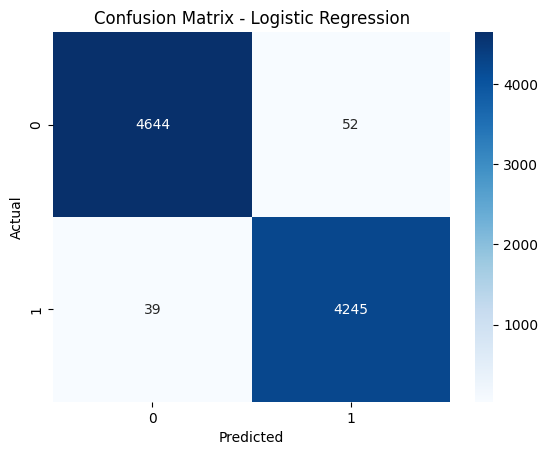

In [81]:
#  Step 11: Evaluate logistic regression Performance
evaluate_model(y_test, y_pred, "Logistic Regression")

In [82]:
#  Step 12: Domain-Wise Evaluation
domain_df = pd.DataFrame({
    "text": X_test.reset_index(drop=True),
    "label": y_test.reset_index(drop=True),
    "domain": domain_test.reset_index(drop=True),
    "pred": y_pred
})

print("\nPerformance by Domain:")
for domain in domain_df['domain'].unique():
    subset = domain_df[domain_df['domain'] == domain]
    acc = accuracy_score(subset['label'], subset['pred'])
    prec = precision_score(subset['label'], subset['pred'])
    rec = recall_score(subset['label'], subset['pred'])
    f1 = f1_score(subset['label'], subset['pred'])

    print(f"\nDomain: {domain}")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Performance by Domain:

Domain: politicsNews
Accuracy: 0.986, Precision: 1.000, Recall: 0.986, F1: 0.993

Domain: News
Accuracy: 0.998, Precision: 0.000, Recall: 0.000, F1: 0.000

Domain: worldnews
Accuracy: 0.996, Precision: 1.000, Recall: 0.996, F1: 0.998

Domain: Middle-east
Accuracy: 0.983, Precision: 0.000, Recall: 0.000, F1: 0.000

Domain: politics
Accuracy: 0.989, Precision: 0.000, Recall: 0.000, F1: 0.000

Domain: US_News
Accuracy: 0.972, Precision: 0.000, Recall: 0.000, F1: 0.000

Domain: left-news
Accuracy: 0.987, Precision: 0.000, Recall: 0.000, F1: 0.000

Domain: Government News
Accuracy: 0.959, Precision: 0.000, Recall: 0.000, F1: 0.000


c:\Users\file_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\file_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\file_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

C:\Users\file_\AppData\Local\Temp\ipykernel_37368\662760561.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients[np.argsort(coefficients)[:top_n]], y=top_fake, palette="Reds_r")
C:\Users\file_\AppData\Local\Temp\ipykernel_37368\662760561.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients[np.argsort(coefficients)[-top_n:]], y=top_real, palette="Blues_r")


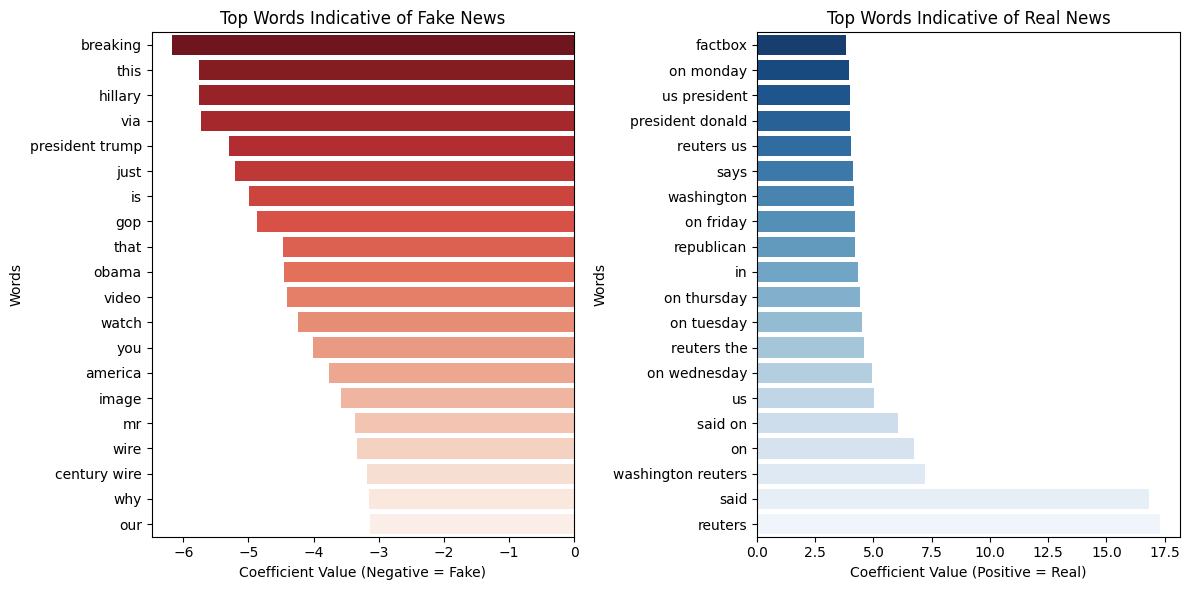

In [83]:
# Step 13: Feature Importance Analysis
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = lr.coef_[0]

top_n = 20
top_fake = feature_names[np.argsort(coefficients)[:top_n]]
top_real = feature_names[np.argsort(coefficients)[-top_n:]]

# Plot top words
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=coefficients[np.argsort(coefficients)[:top_n]], y=top_fake, palette="Reds_r")
plt.title("Top Words Indicative of Fake News")
plt.xlabel("Coefficient Value (Negative = Fake)")
plt.ylabel("Words")

plt.subplot(1, 2, 2)
sns.barplot(x=coefficients[np.argsort(coefficients)[-top_n:]], y=top_real, palette="Blues_r")
plt.title("Top Words Indicative of Real News")
plt.xlabel("Coefficient Value (Positive = Real)")
plt.ylabel("Words")

plt.tight_layout()
plt.show()

## Improved Model

In [94]:
# Step 14: Improved Model - Ensemble with Individually Trained Models

# Define AND train individual models
print(" Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_vec, y_train)

print("Training XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss').fit(X_train_vec, y_train)

# Create and fit ensemble
print(" Training Voting Classifier Ensemble...")
ensemble = VotingClassifier(
    estimators=[
        ('Random Forest', rf),
        ('XGBoost', xgb)
    ],
    voting='soft'
)

ensemble.fit(X_train_vec, y_train)

# Predict with all models
y_pred_rf = rf.predict(X_test_vec)
y_pred_xgb = xgb.predict(X_test_vec)
y_pred_ensemble = ensemble.predict(X_test_vec)

print(" All models and ensemble are now trained.")

 Training Random Forest...
Training XGBoost...


c:\Users\file_\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:34:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Training Voting Classifier Ensemble...


c:\Users\file_\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:37:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 All models and ensemble are now trained.


## Average feature Importance across models

C:\Users\file_\AppData\Local\Temp\ipykernel_37368\4131986811.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Importance', y='Feature', data=top_features, palette="viridis")


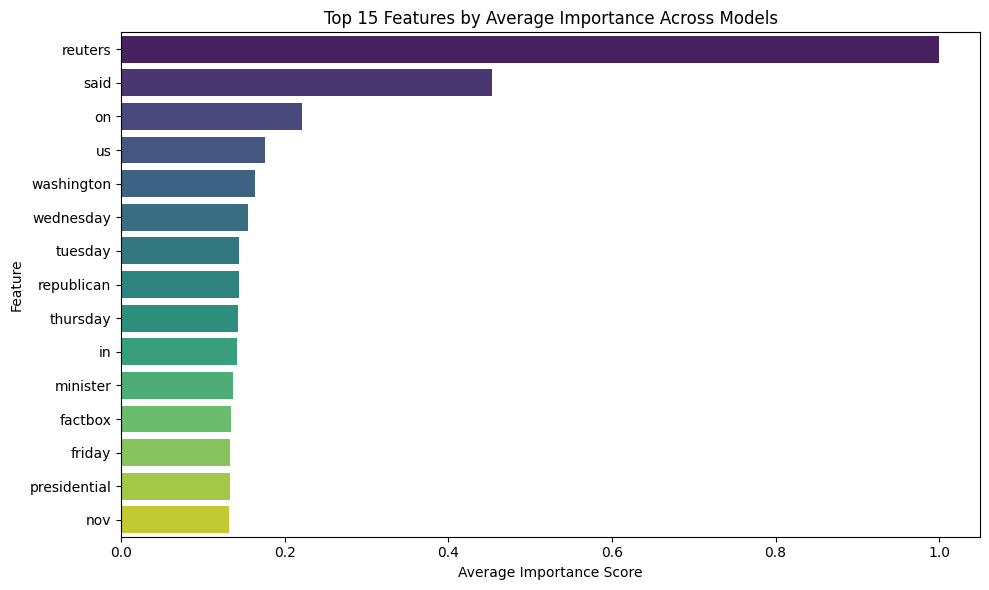

In [98]:
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x='Average Importance', y='Feature', data=top_features, palette="viridis")
plt.title(f"Top {top_n} Features by Average Importance Across Models")
plt.xlabel("Average Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

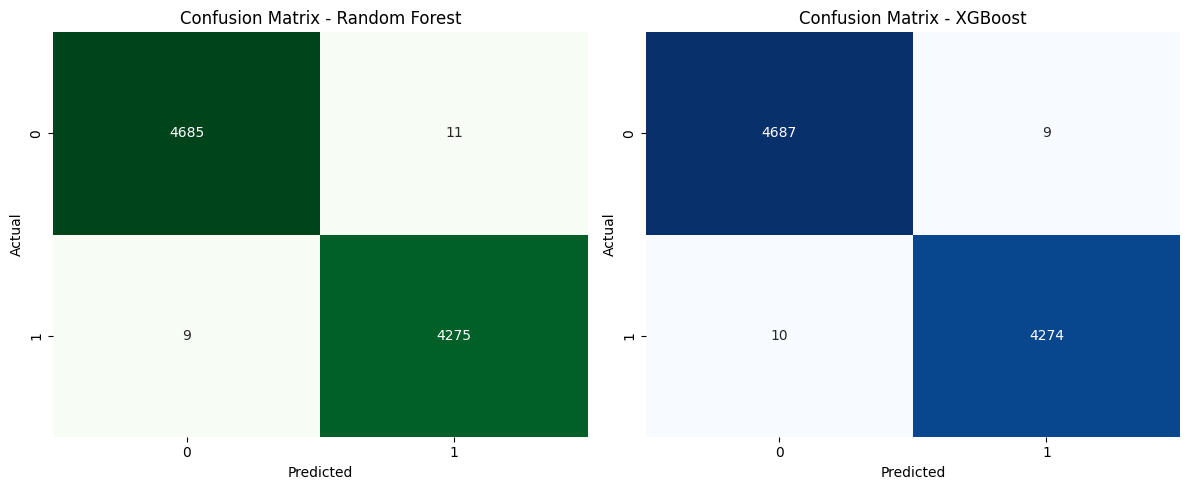

In [99]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix - Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix - XGBoost")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Manual Model performance test on news class

In [95]:
def manual_test_news(model, vectorizer, news_text):
    cleaned_news = clean_text(news_text)
    vectorized_news = vectorizer.transform([cleaned_news])
    prediction = model.predict(vectorized_news)[0]
    return prediction  # Returns 0 for Fake, 1 for Real

In [96]:
print(" Fake vs Real News Classifier - Manual Test Mode")
while True:
    user_input = input("\nEnter a news article (or type 'exit'): ").strip()
    
    if user_input.lower() == 'exit':
        print("Exiting program.")
        break

    print("\nClassifying...\n")

    lr_result = manual_test_news(lr, vectorizer, user_input)
    rf_result = manual_test_news(rf, vectorizer, user_input)
    xgb_result = manual_test_news(xgb, vectorizer, user_input)
    ensemble_result = manual_test_news(ensemble, vectorizer, user_input)

    print("Prediction Results:")
    print(f"Logistic Regression: {'REAL News' if lr_result == 1 else 'FAKE News'}")
    print(f"Random Forest:     {'REAL News' if rf_result == 1 else 'FAKE News'}")
    print(f"XGBoost:         {'REAL News' if xgb_result == 1 else 'FAKE News'}")
    print(f"Ensemble:        {'REAL News' if ensemble_result == 1 else 'FAKE News'}")

 Fake vs Real News Classifier - Manual Test Mode

Classifying...

Prediction Results:
Logistic Regression: FAKE News
Random Forest:     FAKE News
XGBoost:         FAKE News
Ensemble:        FAKE News

Classifying...

Prediction Results:
Logistic Regression: FAKE News
Random Forest:     FAKE News
XGBoost:         FAKE News
Ensemble:        FAKE News
Exiting program.
